In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
import sys
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
#chachacha
from statistics import mode
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
import sys
%matplotlib inline

In [2]:
# -------------------------
################################################### Non-Calibrated data ##########################################

#FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
#FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

################################################### Calibrated rECa data ##########################################

FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/middelkerke_421S_calibrated_rECa.csv'
FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/transects/middelkerke_421S_transect_calibrated_rECa.csv'
samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/samples_merge_rECa_mkerke.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 't', 'HCP1.0', 'PRP1.1', 'HCP2.0',
       'PRP2.1', 'HCP4.0', 'PRP4.1', 'HCP1.0_inph', 'PRP1.1_inph',
       'HCP2.0_inph', 'PRP2.1_inph', 'HCP4.0_inph', 'PRP4.1_inph', 'name',
       'x_clhs', 'y_clhs', 'z.1', 't.1', 'depth', 'humus', 'pH_eau', 'CEC',
       'clay', 'TOC', 'silt', 'sand', 'caCO', 'TOC.1', 'bd', 'vwc', 'copeky',
       'temp', 'rperm', 'iperm'],
      dtype='object')

## Preprocesingn

In [3]:
ds_c = ds.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

# Caclculate Bulk EC from HydraProbe data at 0 Hz
def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds_c.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds_c.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_c['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds_c['bulk_ec_dc_hp_t'] = SheetsHendrickxEC( ds_c.bulk_ec_dc_hp, ds_c.temp)

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

# Caclculate Aparent Bulk EC from EMI at 0 Hz in S/m
EC_columns = ['HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1'] 

for col in EC_columns:
    ds_c[col] = ds_c[col]
   
ds_c

,Unnamed: 0,x,y,z,t,HCP1.0,PRP1.1,HCP2.0,PRP2.1,HCP4.0,...,copeky,temp,rperm,iperm,bulk_ec_hp,bulk_ec_dc_hp,bulk_ec_dc_hp_t,water_ec_hp,water_ec_hp_t,iperm_water_t
0,5793,41564.554,204206.597,0.550000,46700.42,150.158994,72.924179,226.953252,115.025705,373.365468,...,13,32.7,10.700,10.300,0.016247,0.00368,0.003170,0.193993,0.166944,60.016810
1,11585,41548.710,204311.592,0.849275,48080.26,134.086763,115.131030,161.880664,111.225743,252.692239,...,20,31.1,28.100,35.100,0.046509,0.02260,0.020047,0.154387,0.136948,49.233106
2,7013,41589.749,204167.832,0.550000,46944.42,188.638104,96.941128,279.010673,159.068562,412.452460,...,22,28.3,8.700,6.400,0.011783,0.00186,0.001740,0.200569,0.187797,67.513397
3,25276,41668.939,204238.306,0.450000,53527.92,182.368752,90.934958,274.737296,157.622797,400.916603,...,24,31.6,16.700,18.500,0.026637,0.00991,0.008710,0.167790,0.147428,53.000782
4,8604,41521.704,204334.550,0.850000,47262.62,205.244726,169.078652,256.759837,187.403245,345.966089,...,7,26.2,17.600,20.700,0.028611,0.01114,0.010864,0.168299,0.164272,59.056121
5,19374,41617.197,204259.131,0.614979,51612.30,169.129442,85.762126,249.398651,142.679516,343.484881,...,5,28.3,11.300,6.400,0.013320,0.00239,0.002236,0.145977,0.136681,49.137068
6,13276,41576.966,204271.186,1.150000,48437.26,118.310705,49.394996,189.229027,82.501338,341.191642,...,4,31.1,13.300,13.100,0.020367,0.00603,0.005349,0.175202,0.155412,55.870774
7,12715,41533.471,204357.011,0.650000,48325.06,158.127165,133.004659,195.852041,135.676341,296.332981,...,15,25.4,17.100,18.500,0.027062,0.01018,0.010091,0.165264,0.163929,58.932683
8,25563,41643.025,204298.694,0.650000,53586.61,130.630851,71.278118,191.788825,102.483677,316.432606,...,16,28.6,20.200,20.300,0.031160,0.01273,0.011839,0.153877,0.143236,51.493547
9,28254,41701.023,204261.708,0.050000,54124.14,219.480500,116.363030,315.762249,196.503281,410.538252,...,8,27.2,12.100,13.700,0.019436,0.00547,0.005229,0.191964,0.183675,66.031636


In [4]:
R2_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2', 'Best EC feature 10cm', 'R2 10cm', 
                                      'Best EC feature 50cm', 'R2 50cm', 'Best EC feature combined', 'R2 combined', 'R2 combined2'],
                  index=range(0, 5))

RMSE_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE', 'Best EC feature 10cm', 'RMSE 10cm', 
                                      'Best EC feature 50cm', 'RMSE 50cm', 'Best EC feature combined', 'RMSE combined', 'RMSE combined2'],
                  index=range(0, 5))

R2_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature LT', 'R2 LT', 'Best EC feature LS', 'R2 LS'],
                  index=range(0, 5))

RMSE_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature LT', 'RMSE LT', 'Best EC feature LS', 'RMSE LS'],
                  index=range(0, 5))

## Inversion of DC EMI data

Survey 1/1
30/30 inverted
   Finished inversion


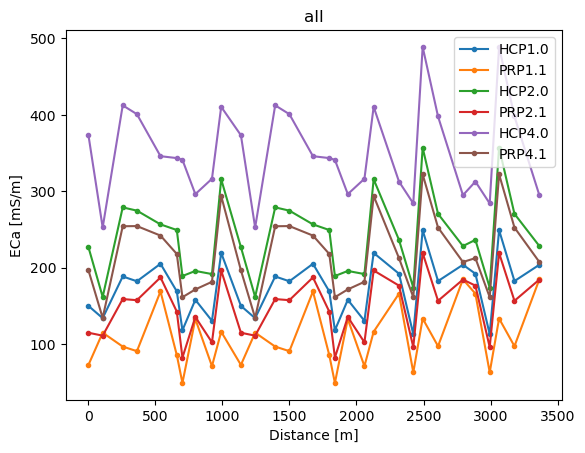

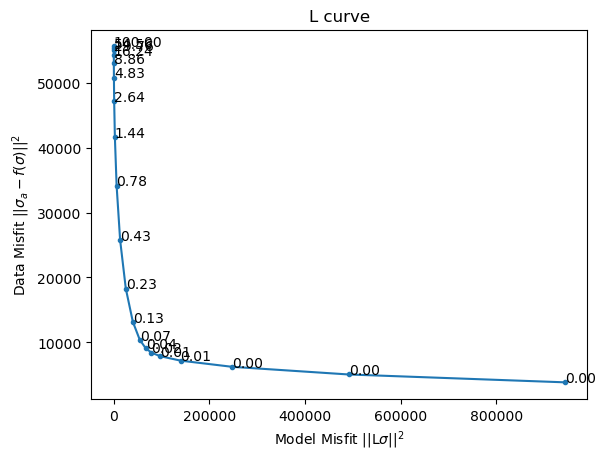

In [5]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9e3,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert( alpha=0.03, forwardModel="CS", method='Gauss-Newton', njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds_c.iloc[:, 3:11], ds_c.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

## 

In [6]:
ds_all['bulk_ec_dc_inv'] = [ds_all['EC_0.40'][i]if ds_all.depth[i] == 10 else ds_all['EC_0.80'][i] for i in range(len(ds_all.vwc))]
ds_all['bulk_ec_dc_inv_t'] = SheetsHendrickxEC(ds_all.bulk_ec_dc_inv, ds_all.temp)
print('ds_all[bulk_ec_dc_inv]', ds_all['bulk_ec_dc_inv'])
print('ds_all[bulk_ec_dc_inv_t]', ds_all['bulk_ec_dc_inv_t'])

ds_all[bulk_ec_dc_inv] 0      55.915333
1     132.853707
2      92.078041
3      86.494608
4     207.730658
5      83.347112
6      22.907583
7     155.362141
8      63.130209
9     126.610630
10     36.798455
11     69.327312
12     89.427804
13     89.945877
14    149.776804
15     94.858220
16     -1.207986
17     88.761555
18     38.704629
19    151.460271
20    144.190476
21     33.643983
22    153.359994
23     89.936330
24    166.232988
25    205.914888
26     56.993361
27    140.680481
28     95.629258
29    236.141267
Name: bulk_ec_dc_inv, dtype: float64
ds_all[bulk_ec_dc_inv_t] 0      48.173689
1     117.845902
2      86.136048
3      76.020640
4     202.591344
5      77.968545
6      20.319830
7     154.003856
8      58.713207
9     121.029935
10     36.777732
11     69.288271
12     89.377443
13     89.895225
14    149.692459
15     94.804802
16     -1.207306
17     88.711570
18     38.682833
19    151.374977
20    144.109276
21     33.625036
22    153.273630
23     89.8856

In [7]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1'
               , 'pH_eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp', 'bulk_ec_dc_inv', 'bulk_ec_dc_inv_t']]

#sns.pairplot(ds_f)

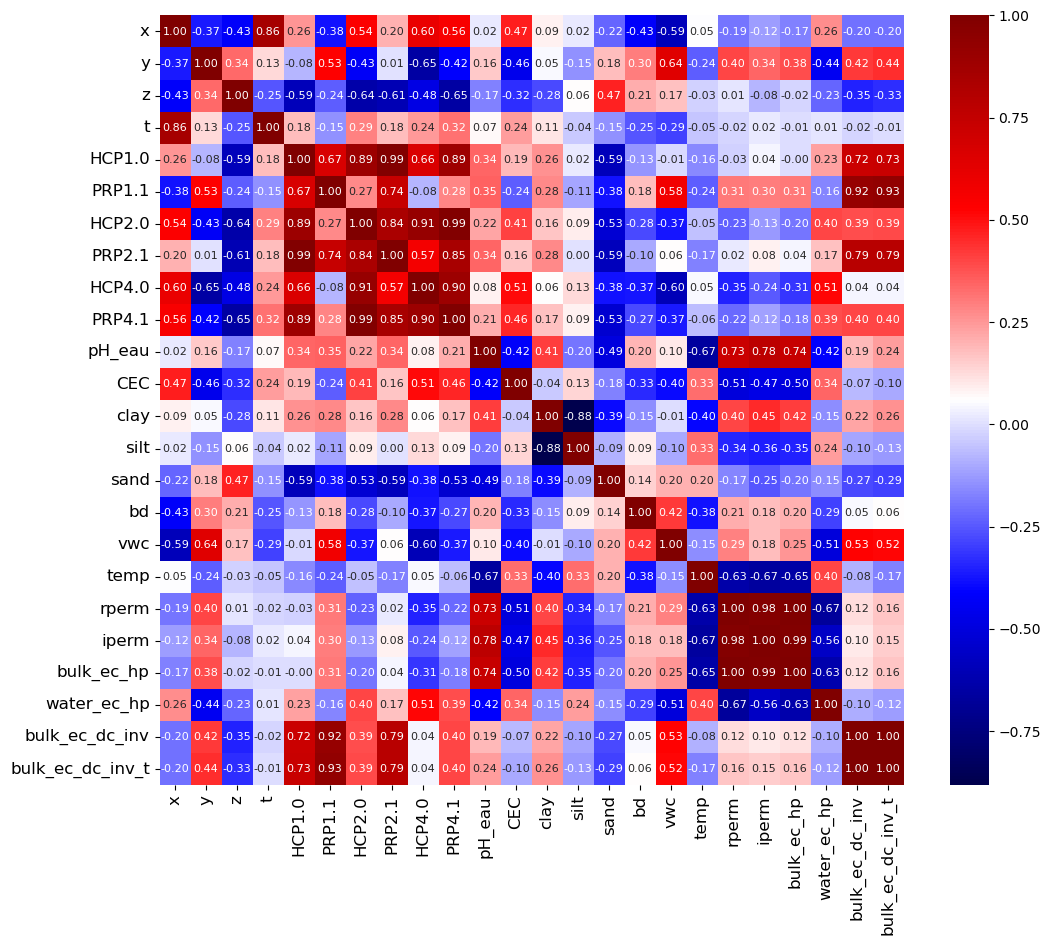

In [8]:
# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

c:\Users\mendo\anaconda3_2\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mendo\anaconda3_2\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


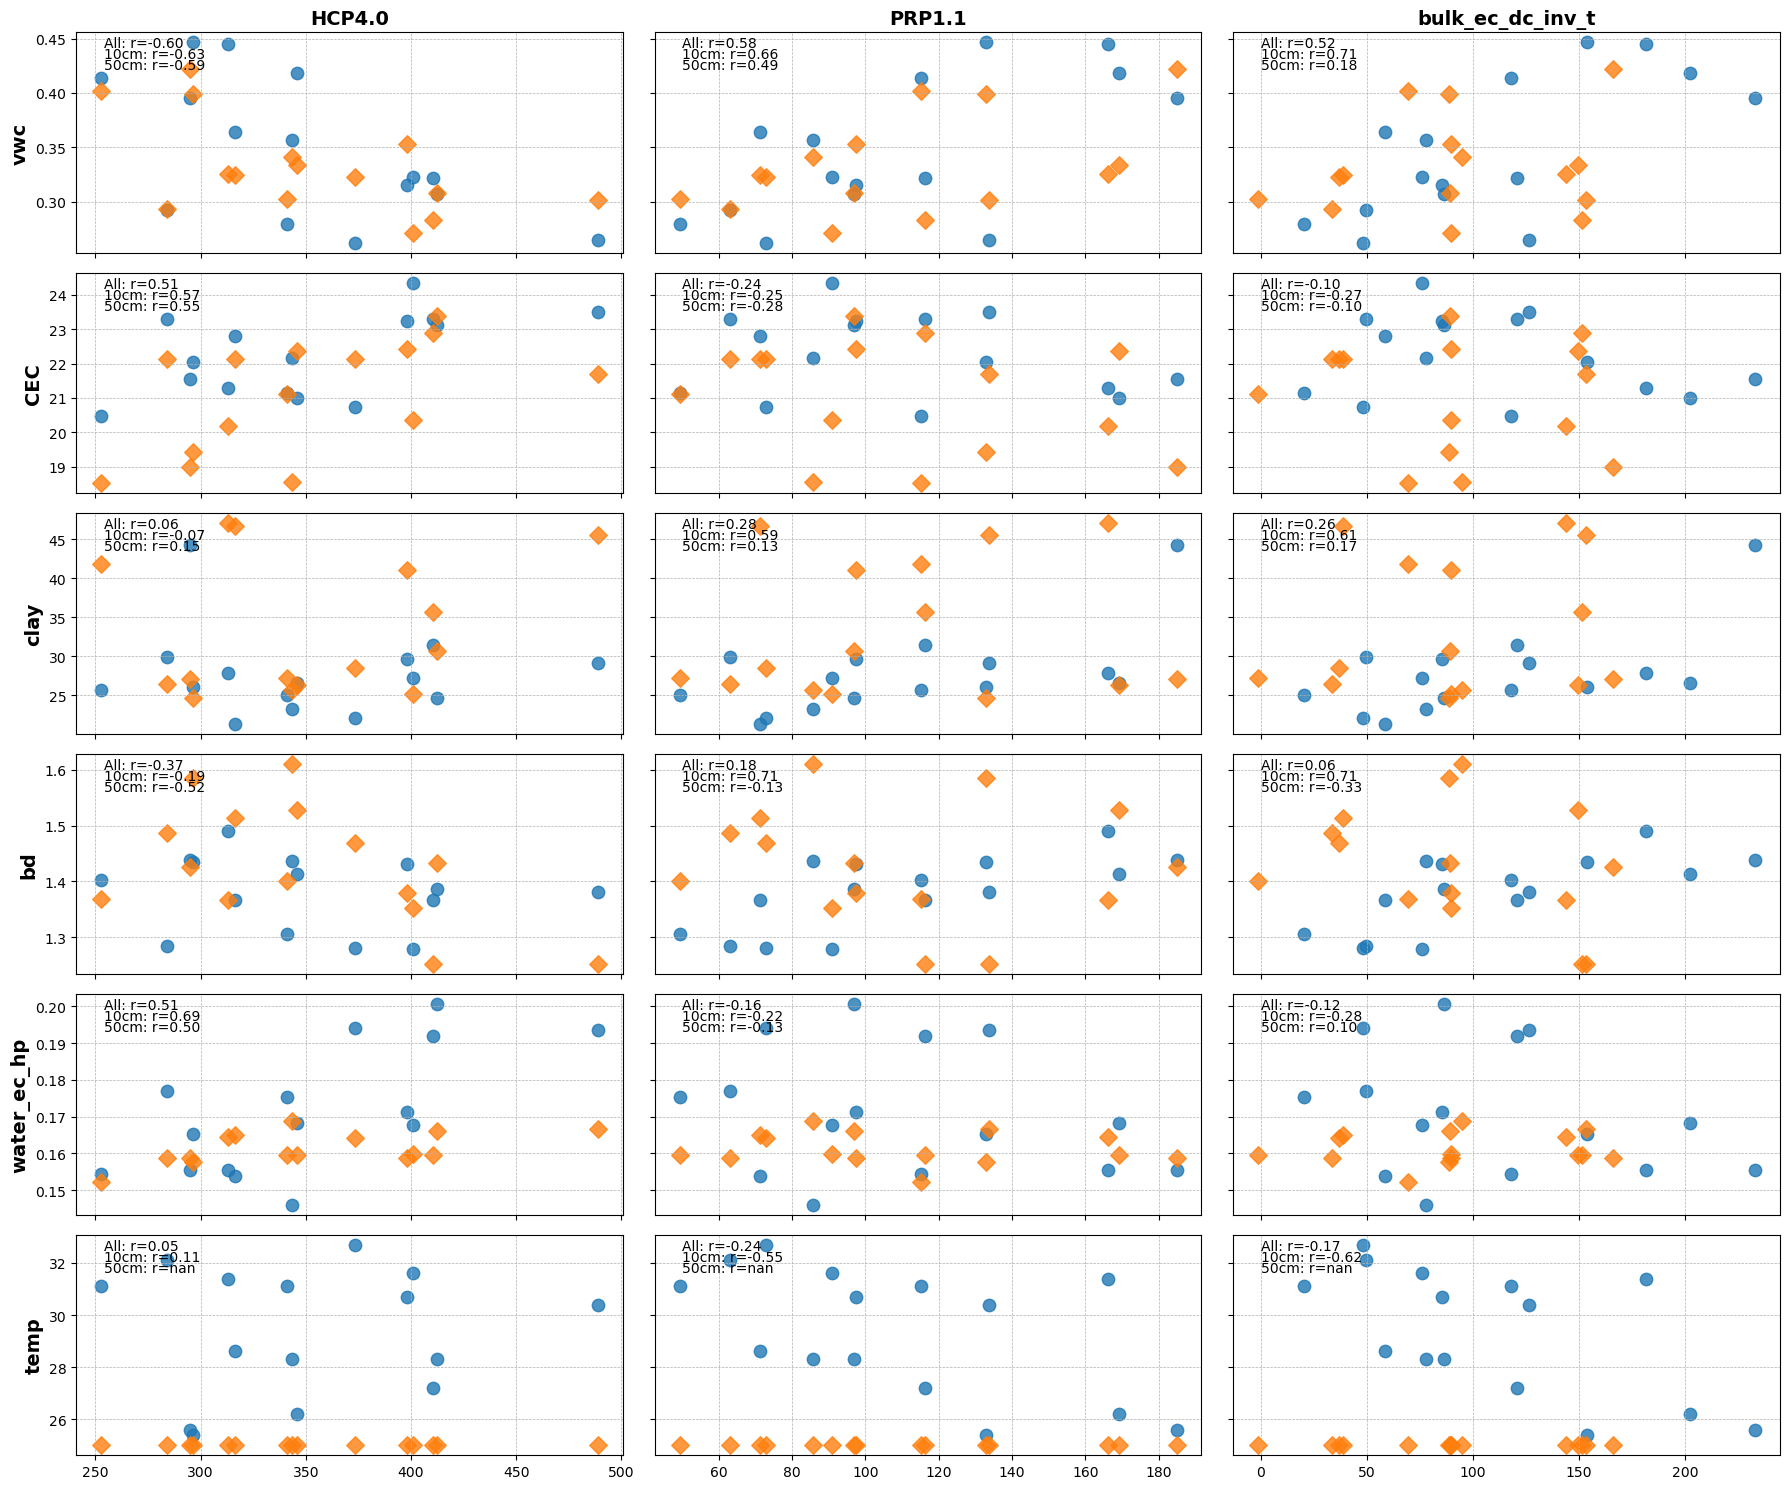

In [9]:
fig, axes = plt.subplots(6, 3, figsize=(18, 15))
ss = 80

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp', 'temp']
preds = ['HCP4.0', 'PRP1.1', 'bulk_ec_dc_inv_t']

def corr_plot(df, preds, targets):

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):

            ax = axes[target_index, pred_index]
            
            # Add grid to the subplot
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                # Calculate correlation coefficient for the specific depth
                corr = np.corrcoef(x_data.dropna(), y_data.dropna())[0, 1]

                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                    ax.text(0.05, 0.9, f'10cm: r={corr:.2f}', transform=ax.transAxes, va="center")
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')
                    ax.text(0.05, 0.85, f'50cm: r={corr:.2f}', transform=ax.transAxes, va="center")

            # Set titles for columns
            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:  # not the bottom row
                ax.set_xticklabels([])

            # Set row labels for the leftmost plots
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:  # not the first column
                ax.set_yticklabels([])

corr_plot(ds_all, preds, targets)
plt.tight_layout()

## Deterministic modelling

In [10]:
clay_50cm = np.mean(ds_all.clay[ds_all['depth']==50])
clay_10cm = np.mean(ds_all.clay[ds_all['depth']==10])
bd_50cm = np.mean(ds_all.bd[ds_all['depth']==50])
bd_10cm = np.mean(ds_all.bd[ds_all['depth']==10])
water_ec_hp_50cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==50])
water_ec_hp_10cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==10])
clay_mean = np.mean(ds_all.clay)
bd_mean = np.mean(ds_all.bd)
water_ec_hp_mean = np.mean(ds_all.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_all.water_ec_hp_t)
temp_50cm = np.mean(ds_all.temp[ds_all['depth']==50])
temp_10cm = np.mean(ds_all.temp[ds_all['depth']==10])
temp_mean = np.mean(ds_all.temp)

rmse_0, mean: 0.054 0.3397196666666666
for predicting water deterministically, the best predictor is:PRP1.1


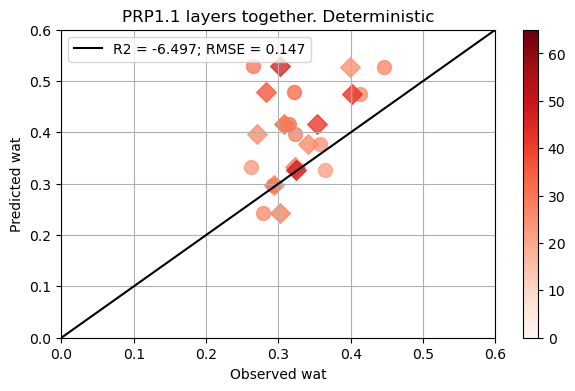

for predicting water deterministically, the best predictor is:PRP1.1


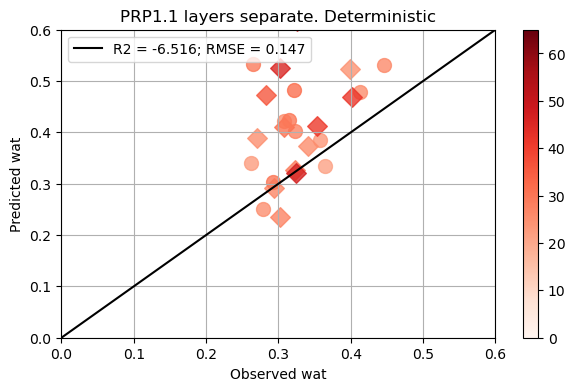

,Target,Best EC feature LT,R2 LT,Best EC feature LS,R2 LS
0,vwc,PRP1.1,-6.497,PRP1.1,-6.516
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [12]:
ds_all['EC mean'] = (ds_all['HCP1.0'] + ds_all['HCP2.0'] + ds_all['HCP4.0']  + ds_all['PRP1.1'] + ds_all['PRP2.1'] + ds_all['PRP4.1'] + ds_all['bulk_ec_dc_inv'])/7 

feature_set = [
    'HCP1.0',
    'HCP2.0',
    'HCP4.0',
    'PRP4.1',
    'PRP1.1',
    'PRP2.1',
    'bulk_ec_dc_inv',
    'bulk_ec_dc_inv_t',
    'EC mean'
]

target = ds_all['vwc']
R2_lt, RMSE_lt, WAT_lt = [], [], []
R2_ls, RMSE_ls, WAT_ls = [], [], []

round_n = 3

for feature in feature_set:
    layers_together = Soil( 
                bulk_ec = ds_all[feature].values/1000,
                frequency_ec=9000,
                clay = clay_mean,
                bulk_density = bd_mean,
                water_ec = water_ec_hp_mean,
                temperature = temp_mean+273.15
                  )
    
    layer_10 = Soil( 
                bulk_ec = ds_all[feature].values/1000,
                frequency_ec=9000,
                clay = clay_10cm,
                bulk_density = bd_10cm,
                water_ec = water_ec_hp_10cm,
                temperature = temp_10cm+273.15
                  )

    layer_50 = Soil( 
                bulk_ec = ds_all[feature].values/1000,
                frequency_ec=9000,
                clay = clay_50cm,
                bulk_density = bd_50cm,
                water_ec = water_ec_hp_50cm,
                temperature = temp_50cm+273.15
                  )
    
    layer_10_wat = predict.Water(layer_10)
    layer_50_wat = predict.Water(layer_50)
    layers_separate = [layer_10_wat[i] if ds_all.depth[i] == 10 else layer_50_wat[i] for i in range(len(ds_all.vwc))]
    
    WAT_ls.append(layers_separate)
    r2_ls = round(r2_score(ds.vwc.values, layers_separate), round_n)
    rmse_ls = round(RMSE(ds.vwc.values, layers_separate), round_n)
    R2_ls.append(r2_ls)
    RMSE_ls.append(rmse_ls)

    wat_lt = predict.Water(layers_together)
    WAT_lt.append(wat_lt)
    r2_lt = round(r2_score(ds.vwc.values, wat_lt), round_n)
    rmse_lt = round(RMSE(ds.vwc.values, wat_lt), round_n)
    R2_lt.append(r2_lt)
    RMSE_lt.append(rmse_lt)

print('rmse_0, mean:', round(RMSE(ds.vwc.values, np.mean(ds.vwc.values)), round_n), np.mean(ds.vwc.values))

best_index_lt = RMSE_lt.index(np.min(RMSE_lt))
R2_deterministic['R2 LT'][0] = R2_lt[best_index_lt]
RMSE_deterministic['RMSE LT'][0] = RMSE_lt[best_index_lt]
R2_deterministic['Best EC feature LT'][0] = feature_set[best_index_lt]
RMSE_deterministic['Best EC feature LT'][0] = feature_set[best_index_lt]
R2_deterministic['Target'][0] = 'vwc'
RMSE_deterministic['Target'][0] = 'vwc'

print('for predicting water deterministically, the best predictor is:' +feature_set[best_index_lt])
plot_results(ds_all, target, WAT_lt[best_index_lt], R2_lt[best_index_lt], RMSE_lt[best_index_lt], ds_all.clay, feature_set[best_index_lt]+' layers together. Deterministic')

best_index_ls = RMSE_ls.index(np.min(RMSE_ls))
R2_deterministic['R2 LS'][0] = R2_ls[best_index_ls]
RMSE_deterministic['RMSE LS'][0] = RMSE_ls[best_index_ls]
R2_deterministic['Best EC feature LS'][0] = feature_set[best_index_ls]
RMSE_deterministic['Best EC feature LS'][0] = feature_set[best_index_ls]
R2_deterministic['Target'][0] = 'vwc'
RMSE_deterministic['Target'][0] = 'vwc'

print('for predicting water deterministically, the best predictor is:' +feature_set[best_index_ls])
plot_results(ds_all, target, WAT_ls[best_index_ls], R2_ls[best_index_ls], RMSE_ls[best_index_ls], ds_all.clay, feature_set[best_index_ls]+' layers separate. Deterministic')

R2_deterministic

In [13]:
RMSE_deterministic

,Target,Best EC feature LT,RMSE LT,Best EC feature LS,RMSE LS
0,vwc,PRP1.1,0.147,PRP1.1,0.147
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


## Stochastic modelling (no layer distinction)

In [14]:
feature_sets = [
    ['HCP1.0'],
    ['HCP2.0'],
    ['HCP4.0'],
    ['HCP4.0', 'HCP1.0'],
    ['HCP1.0', 'HCP2.0'],
    ['HCP4.0', 'HCP2.0'],
#    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
    ['PRP4.1'],
    ['PRP1.1'],
    ['PRP2.1'],
    ['PRP4.1', 'PRP1.1'],
    ['PRP4.1', 'PRP2.1'],
    ['PRP1.1', 'PRP2.1'],
#    ['PRP0.6', 'PRP1.1', 'PRP2.1'], 
    ['PRP4.1', 'HCP1.0'],
    ['bulk_ec_dc_inv'],
    ['bulk_ec_dc_inv_t'],
    ['EC mean']
#    ['bulk_ec_dc_inv', 'PRP0.6', 'HCP0.5']
]

In [15]:
def stochastic_poly(df, feature_columns, Y, n=4, iters=100, round_n=3):
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []
    X = df[feature_columns[0]].values.reshape(-1, 1)
    
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)
            Xt_test = poly.transform(X_test)

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]
    
    RMSE_sums = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_sums.index(np.min(RMSE_sums))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)         


def implementation(df, features, target, n):           
    # Create a polynomial regression model
    if isinstance(features, (list, tuple)):
        X = df[list(features)]
    else:
        X = df[features][:, np.newaxis]
    
    # Create a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())
    model.fit(X, df[target])
    
    # Predict y values
    predictions = model.predict(X)
    
    # Compute R^2 and RMSE
    r2 = r2_score(df[target], predictions)
    rmse = RMSE(df[target], predictions)
    
    # For plotting purposes, we'll use the first feature in the list (or the only feature)
    primary_feature = features[0] if isinstance(features, (list, tuple)) else features
    x_fit = np.linspace(min(df[primary_feature]), max(df[primary_feature]), 500)
    
    # If multiple features, we need to ensure the shape of x_fit matches
    if isinstance(features, (list, tuple)) and len(features) > 1:
        X_fit = pd.DataFrame({feature: x_fit if feature == primary_feature else df[feature].values 
                              for feature in features})
    else:
        X_fit = x_fit[:, np.newaxis]
    
    y_fit = model.predict(X_fit)
    
    # Plotting
    plt.scatter(df[primary_feature], df[target], label='Data Points')
    
    # Plot points where df['depth'] == 50 with 'D' marker
    depth_mask = df['depth'] == 50
    plt.scatter(df[primary_feature][depth_mask], df[target][depth_mask], marker='D', label='Depth=50 Points')
    
    plt.plot(x_fit, y_fit, color='black', label=f'Polynomial (Degree {n}) Fit')
    plt.title(f'Polynomial Fit of Degree {n}\n$R^2$: {r2:.2f}, RMSE: {rmse:.2f}')
    plt.xlabel(primary_feature)
    plt.ylabel(target)
    plt.legend()
    plt.show()
    
    return model

i 0
for predicting stochastically vwc the best predictor is:HCP4.0


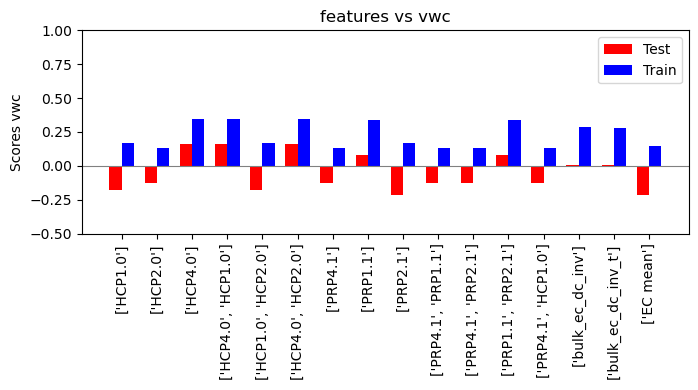

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


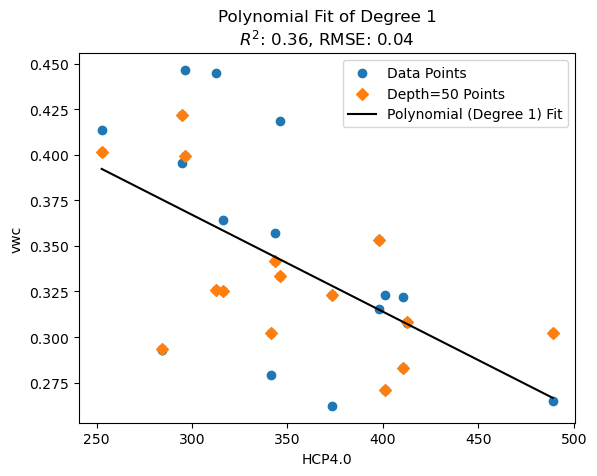

i 1
for predicting stochastically CEC the best predictor is:HCP4.0


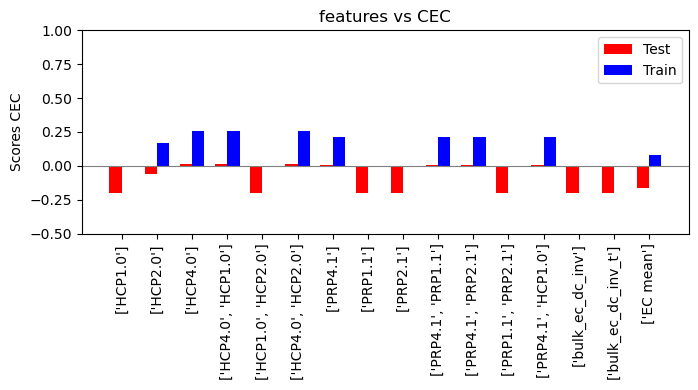

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


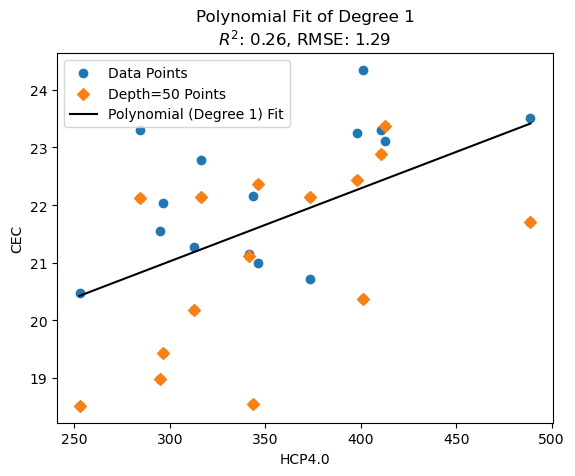

i 2
for predicting stochastically clay the best predictor is:HCP1.0


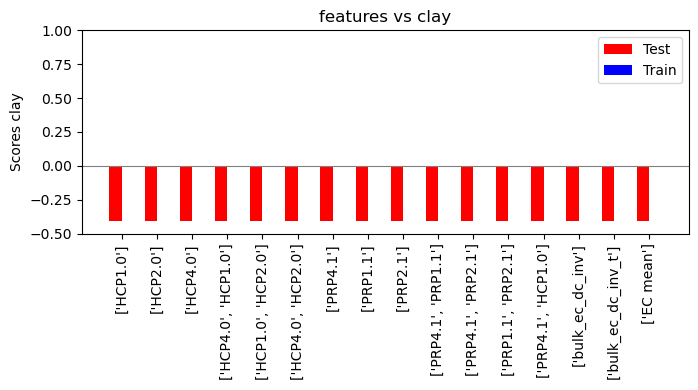

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


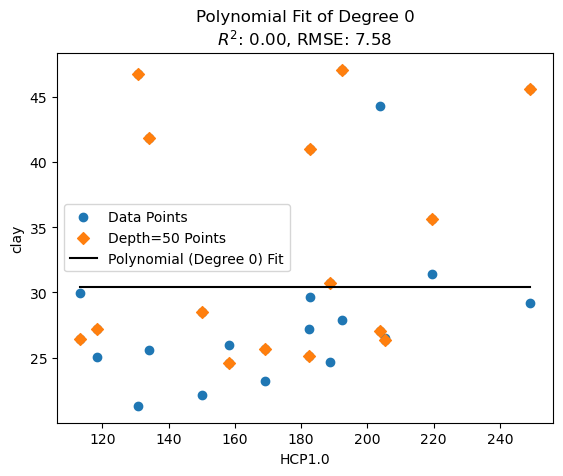

i 3
for predicting stochastically bd the best predictor is:HCP4.0


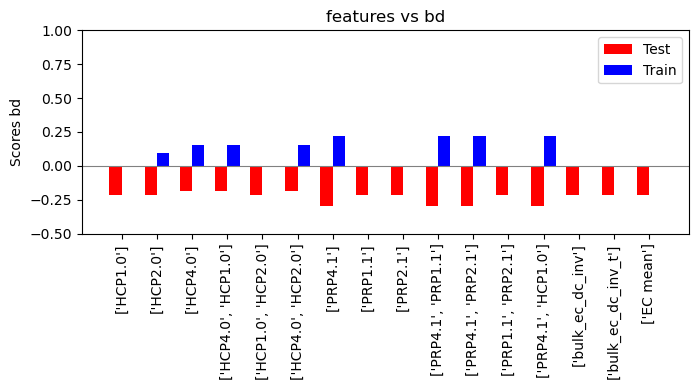

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


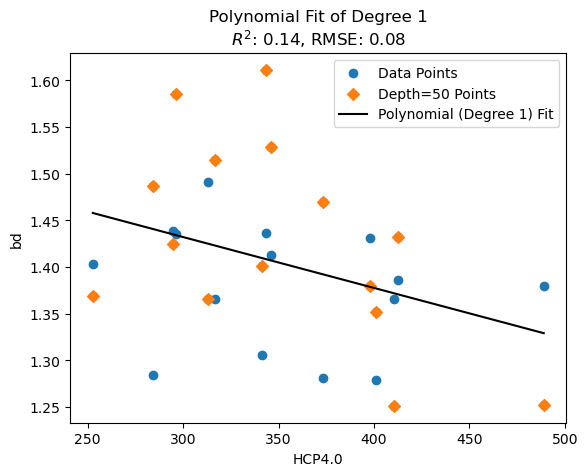

i 4
for predicting stochastically water_ec_hp the best predictor is:HCP4.0


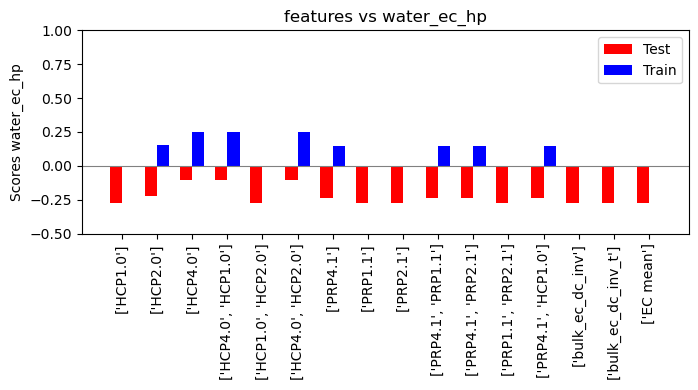

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


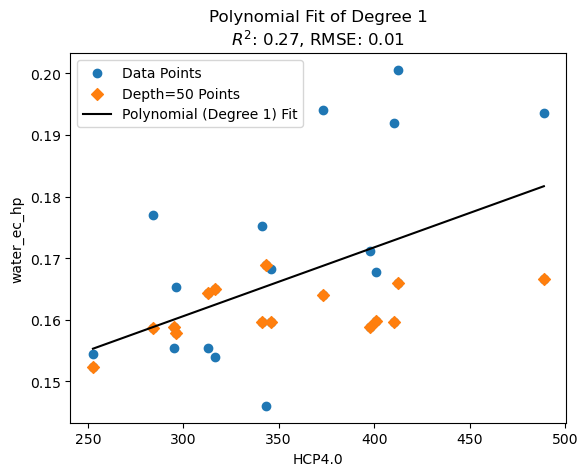

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(HCP4.0, 1)",0.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(HCP4.0, 1)",0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(HCP1.0, 0)",-0.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(HCP4.0, 1)",-0.183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp,"(HCP4.0, 1)",-0.105,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

i = 0
for t in target_set:
    print('i', i)
    R2_test, R2_train, RMSE_test, n_ = [], [], [], []
    target = ds_all[t].values
    
    for feature_set in feature_sets:        
        best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds_all, feature_set, target)
        #print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        RMSE_test.append(RMSE_test_pol)
        n_.append(best_n)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n = n_[best_index]
    
    R2_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE'][i] = RMSE_test[best_index]

    print('for predicting stochastically '+ t+' the best predictor is:' +feature_sets[best_index][0])
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n)

    i+=1
R2_stochastic

In [17]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(HCP4.0, 1)",0.045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(HCP4.0, 1)",1.416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(HCP1.0, 0)",7.626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(HCP4.0, 1)",0.089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp,"(HCP4.0, 1)",0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Layered stochastic modelling

In [18]:
def stochastic_poly_(df, feature_columns, target, n=4, iters=100, round_n=3):
    R2_train_t_10_, R2_test_t_10_, RMSE_train_t_10_, RMSE_test_t_10_, ypred_test_10_ = [], [], [], [], []
    R2_train_t_50_, R2_test_t_50_, RMSE_train_t_50_, RMSE_test_t_50_, ypred_test_50_ = [], [], [], [], []
    R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], []
    y_test_ = []

    for i in range(iters):

        X_layer_10 = df[df['depth'] == 10][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_10 = df[df['depth'] == 10][target].values

        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        R2_train_t_10, R2_test_t_10, RMSE_train_t_10, RMSE_test_t_10, ypred_test_10 = [], [], [], [], []
######
######
        X_layer_50 = df[df['depth'] == 50][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_50 = df[df['depth'] == 50][target].values

        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        R2_train_t_50, R2_test_t_50, RMSE_train_t_50, RMSE_test_t_50, ypred_test_50 = [], [], [], [], []
        
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50))
        y_test_.append(y_test)
        R2_train_t_comb, R2_test_t_comb, RMSE_train_t_comb, RMSE_test_t_comb = [], [], [], []
        
        for k in range(n):
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)

            LinReg10.fit(Xt_train10, y_train10)
            ypred_train10 = LinReg10.predict(Xt_train10)
            ypred_test10 = LinReg10.predict(Xt_test10)
            ypred_test_10.append(ypred_test10)

            R2_train_t10 = r2_score(y_train10, ypred_train10)
            R2_test_t10 = r2_score(y_test10, ypred_test10)
            RMSE_train_t10 = RMSE(y_train10, ypred_train10)
            RMSE_test_t10 = RMSE(y_test10, ypred_test10)

            R2_train_t_10.append(R2_train_t10)
            R2_test_t_10.append(R2_test_t10)
            RMSE_train_t_10.append(RMSE_train_t10)
            RMSE_test_t_10.append(RMSE_test_t10)

            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)

            LinReg50.fit(Xt_train50, y_train50)
            ypred_train50 = LinReg50.predict(Xt_train50)
            ypred_test50 = LinReg50.predict(Xt_test50)
            ypred_test_50.append(ypred_test50)

            ypred_train = np.concatenate((ypred_train10, ypred_train50))
            ypred_test = np.concatenate((ypred_test10, ypred_test50))

            R2_train_t50 = r2_score(y_train50, ypred_train50)
            R2_test_t50 = r2_score(y_test50, ypred_test50)
            RMSE_train_t50 = RMSE(y_train50, ypred_train50)
            RMSE_test_t50 = RMSE(y_test50, ypred_test50)

            R2_train_t_50.append(R2_train_t50)
            R2_test_t_50.append(R2_test_t50)
            RMSE_train_t_50.append(RMSE_train_t50)
            RMSE_test_t_50.append(RMSE_test_t50)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        R2_train_t_10_.append(R2_train_t_10)
        R2_test_t_10_.append(R2_test_t_10)
        RMSE_train_t_10_.append(RMSE_train_t_10)
        RMSE_test_t_10_.append(RMSE_test_t_10)
        ypred_test_10_.append(ypred_test_10)

        R2_train_t_50_.append(R2_train_t_50)
        R2_test_t_50_.append(R2_test_t_50)
        RMSE_train_t_50_.append(RMSE_train_t_50)
        RMSE_test_t_50_.append(RMSE_test_t_50)
        ypred_test_50_.append(ypred_test_50)

        R2_train_t_comb.append(R2_train_t_)
        R2_test_t_comb.append(R2_test_t_)
        RMSE_train_t_comb.append(RMSE_train_t_)
        RMSE_test_t_comb.append(RMSE_test_t_)

    RMSE_test_n1_10 = [inner_list[0] for inner_list in RMSE_test_t_10_]
    RMSE_test_n2_10 = [inner_list[1] for inner_list in RMSE_test_t_10_]
    RMSE_test_n3_10 = [inner_list[2] for inner_list in RMSE_test_t_10_]
    RMSE_test_n4_10 = [inner_list[3] for inner_list in RMSE_test_t_10_]

    RMSE_test_n1_50 = [inner_list[0] for inner_list in RMSE_test_t_50_]
    RMSE_test_n2_50 = [inner_list[1] for inner_list in RMSE_test_t_50_]
    RMSE_test_n3_50 = [inner_list[2] for inner_list in RMSE_test_t_50_]
    RMSE_test_n4_50 = [inner_list[3] for inner_list in RMSE_test_t_50_]

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_comb]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_comb]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_comb]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_comb]

    RMSE_mean_10 = [np.mean(RMSE_test_n1_10), np.mean(RMSE_test_n2_10), np.mean(RMSE_test_n3_10), np.mean(RMSE_test_n4_10)]
    best_n_10 = RMSE_mean_10.index(np.min(RMSE_mean_10))

    RMSE_mean_50 = [np.mean(RMSE_test_n1_50), np.mean(RMSE_test_n2_50), np.mean(RMSE_test_n3_50), np.mean(RMSE_test_n4_50)]
    best_n_50 = RMSE_mean_50.index(np.min(RMSE_mean_50))

    RMSE_mean = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_mean.index(np.min(RMSE_mean))

    for j in range(iters):
        _10 = [inner_list[best_n_10] for inner_list in ypred_test_10_][j]
        _50 = [inner_list[best_n_50] for inner_list in ypred_test_50_][j]
        ypred_1050 = np.concatenate((_10, _50))

        ytest_1050 =  y_test_[j]

        R2_1050 = r2_score(ytest_1050, ypred_1050)
        RMSE_1050 = RMSE(ytest_1050, ypred_1050)

    return best_n_10, round(np.mean([inner_list[best_n_10] for inner_list in R2_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in R2_train_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_train_t_10_]), round_n), best_n_50, round(np.mean([inner_list[best_n_50] for inner_list in R2_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in R2_train_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_train_t_50_]), round_n), best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_comb]), round_n), round(R2_1050, round_n), round(RMSE_1050, round_n)   

Predicting stochastically vwc with combined layer modelling, the best predictor is: HCP4.0 with ply grade: 1


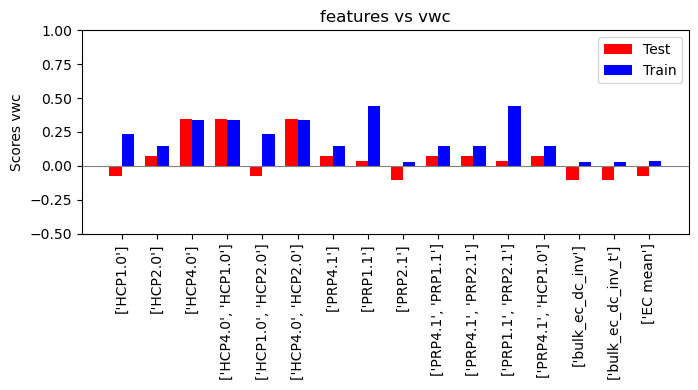

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


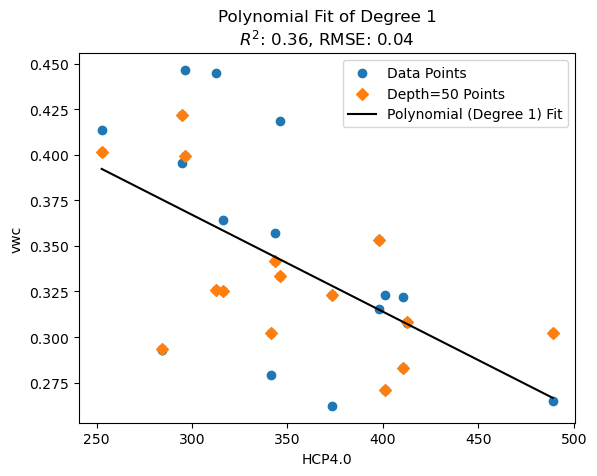

Predicting stochastically vwc for the 10 cm layer, the best predictor is: bulk_ec_dc_inv with ply grade: 1


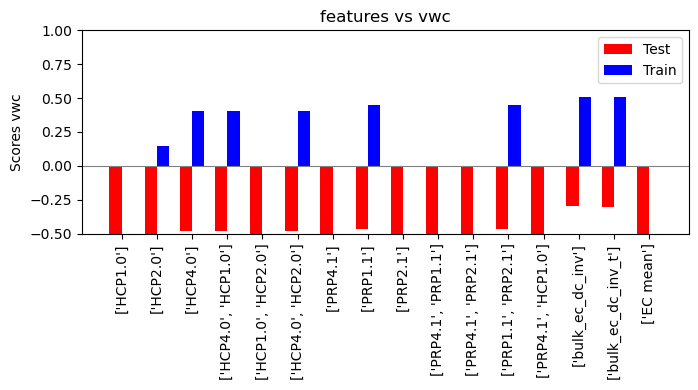

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


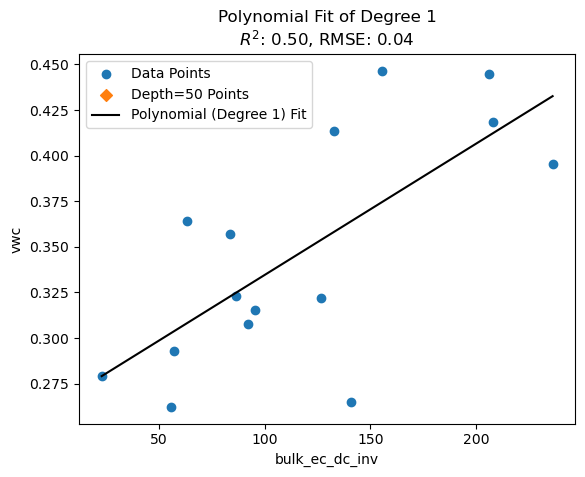

Predicting stochastically vwc for the 50 cm layer, the best predictor is: HCP4.0 with ply grade: 2


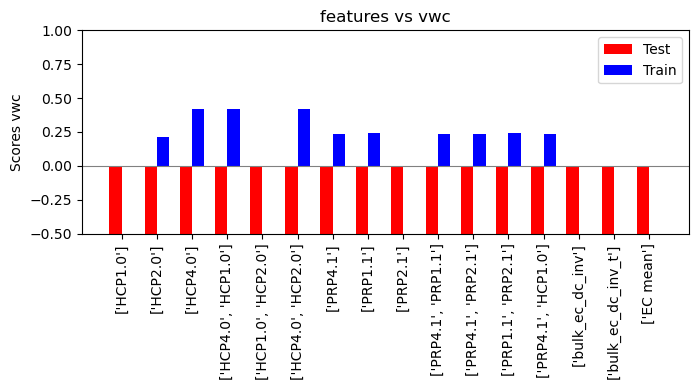

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


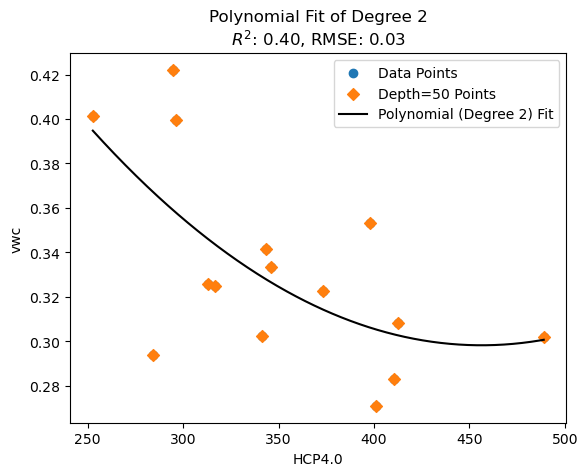

Predicting stochastically CEC with combined layer modelling, the best predictor is: HCP4.0 with ply grade: 1


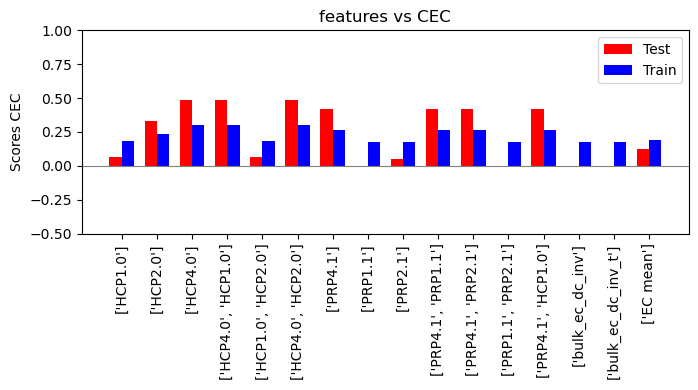

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


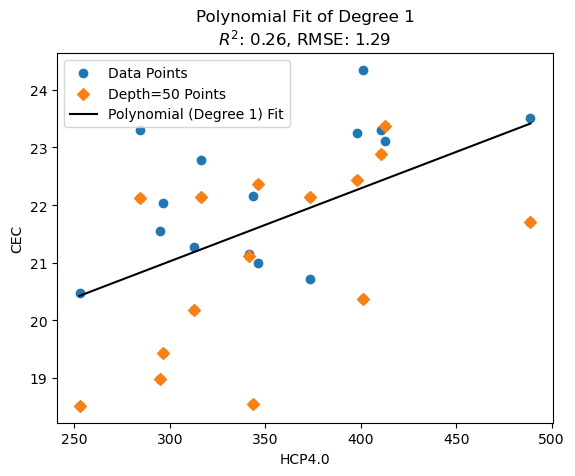

Predicting stochastically CEC for the 10 cm layer, the best predictor is: PRP4.1 with ply grade: 1


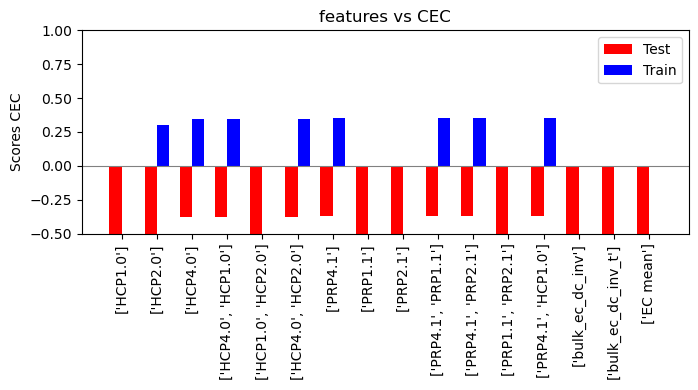

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


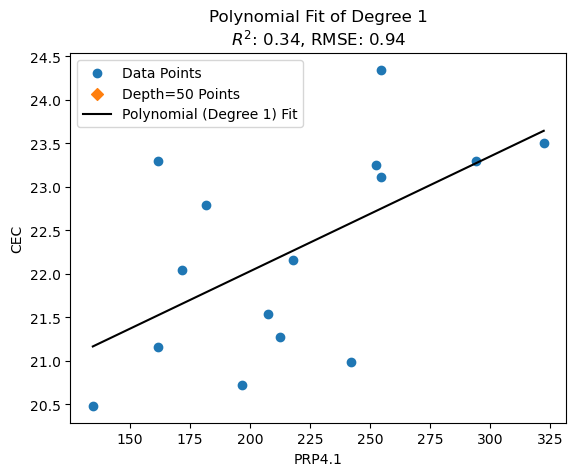

Predicting stochastically CEC for the 50 cm layer, the best predictor is: HCP4.0 with ply grade: 1


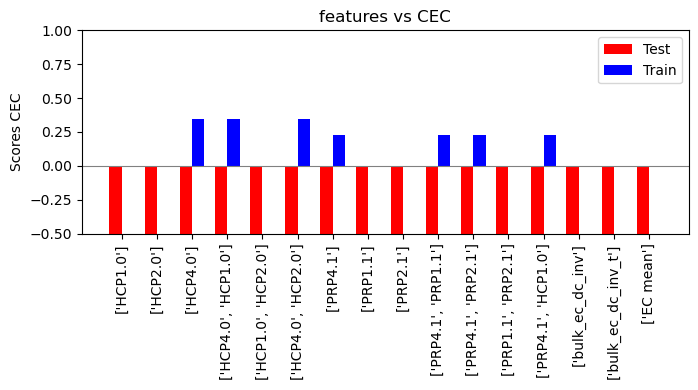

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


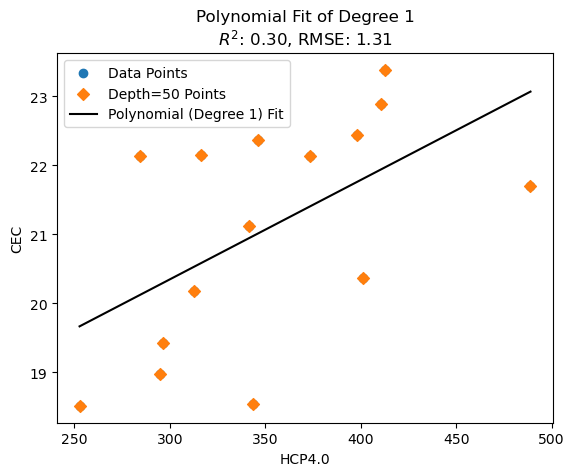

Predicting stochastically clay with combined layer modelling, the best predictor is: HCP1.0 with ply grade: 0


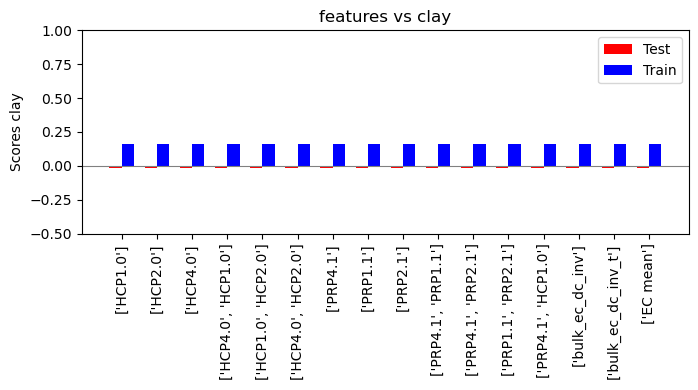

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


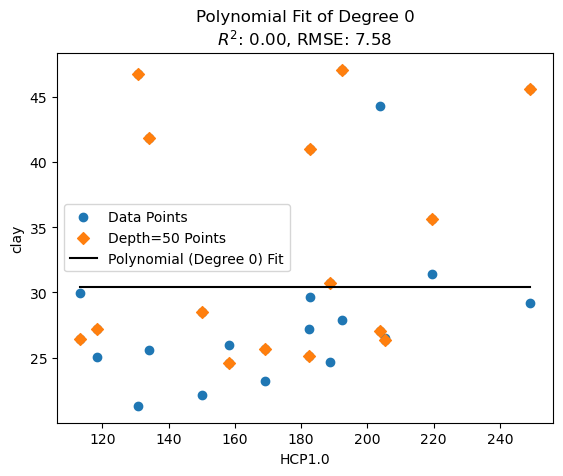

Predicting stochastically clay for the 10 cm layer, the best predictor is: HCP1.0 with ply grade: 0


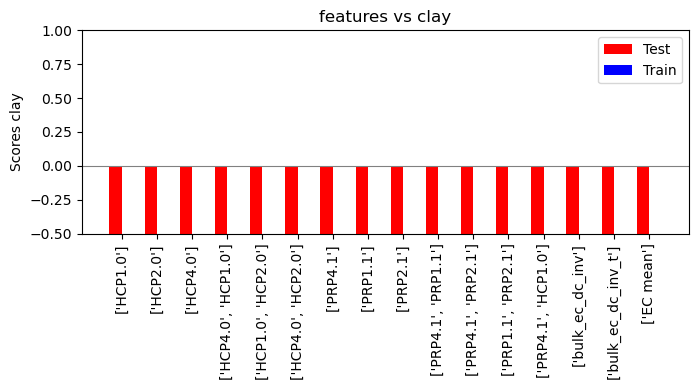

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


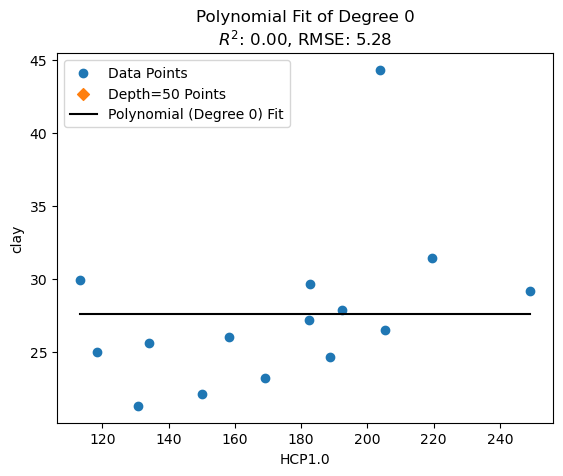

Predicting stochastically clay for the 50 cm layer, the best predictor is: HCP1.0 with ply grade: 0


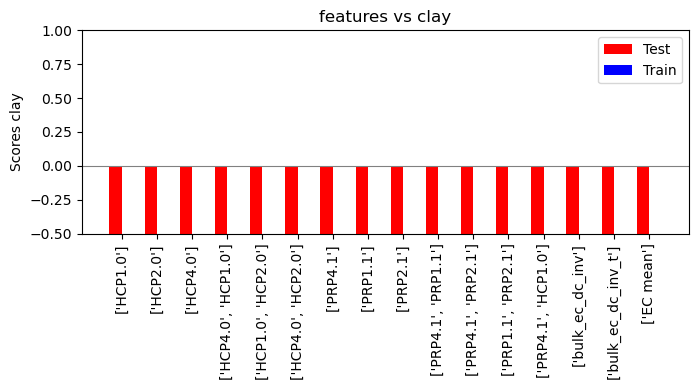

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


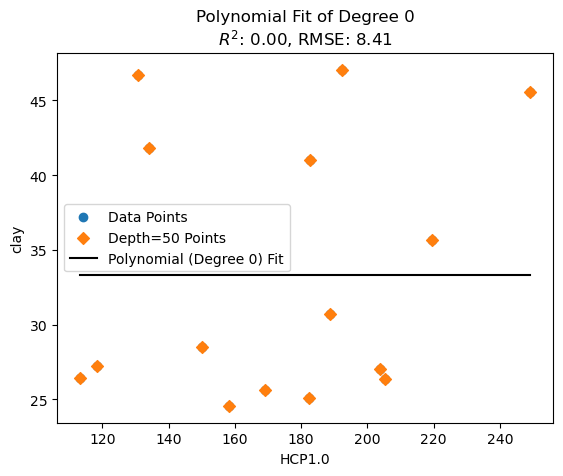

Predicting stochastically bd with combined layer modelling, the best predictor is: EC mean with ply grade: 3


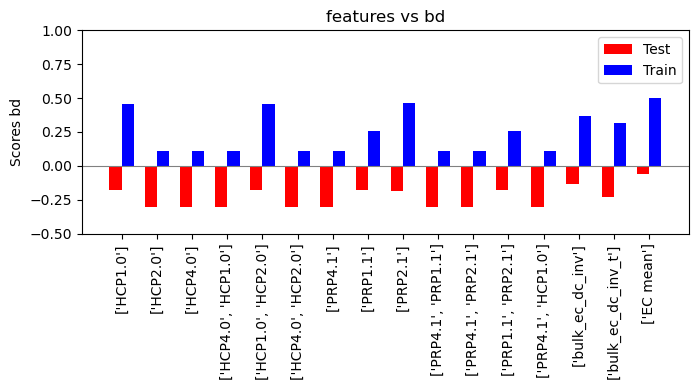

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


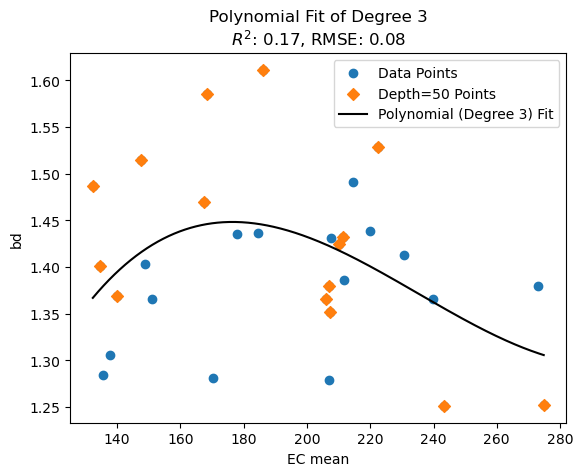

Predicting stochastically bd for the 10 cm layer, the best predictor is: bulk_ec_dc_inv with ply grade: 1


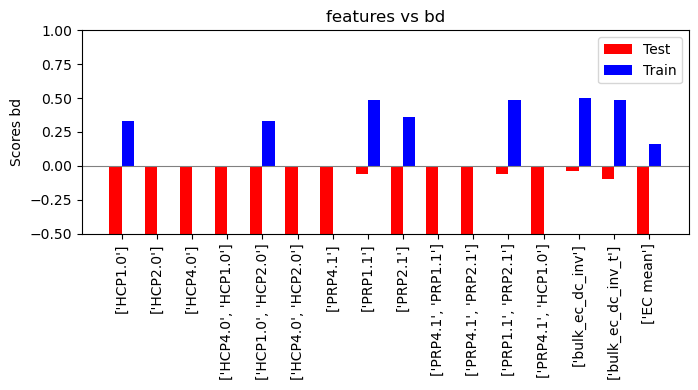

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


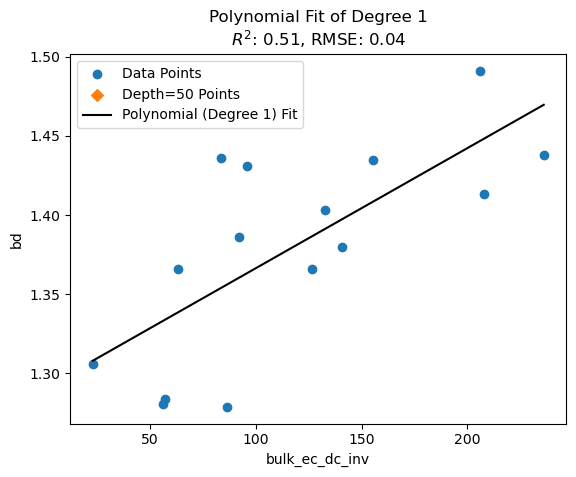

Predicting stochastically bd for the 50 cm layer, the best predictor is: HCP2.0 with ply grade: 1


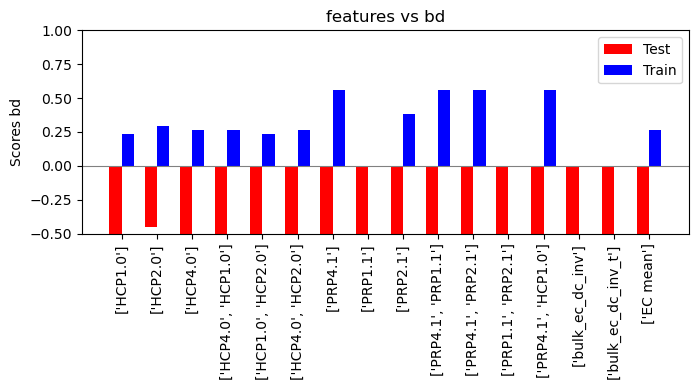

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


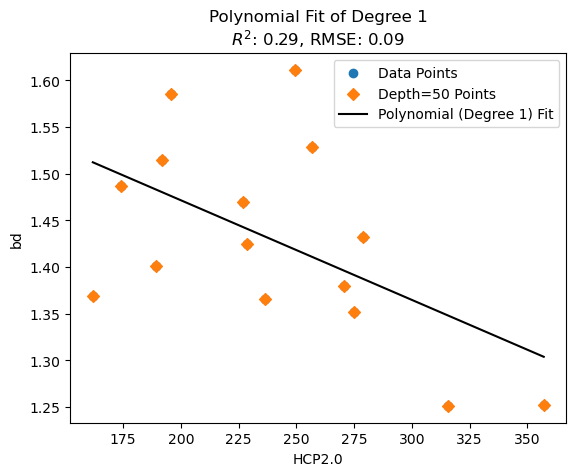

Predicting stochastically water_ec_hp with combined layer modelling, the best predictor is: HCP4.0 with ply grade: 1


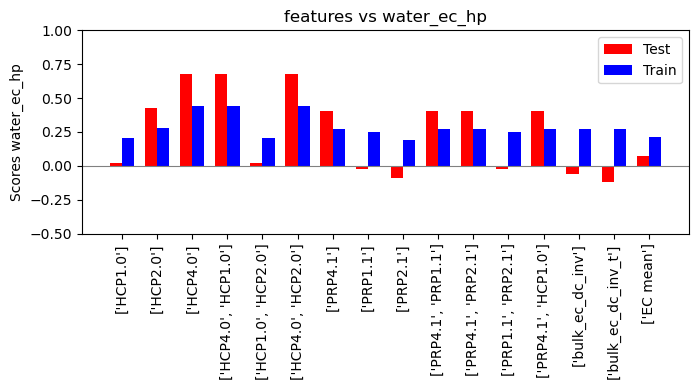

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


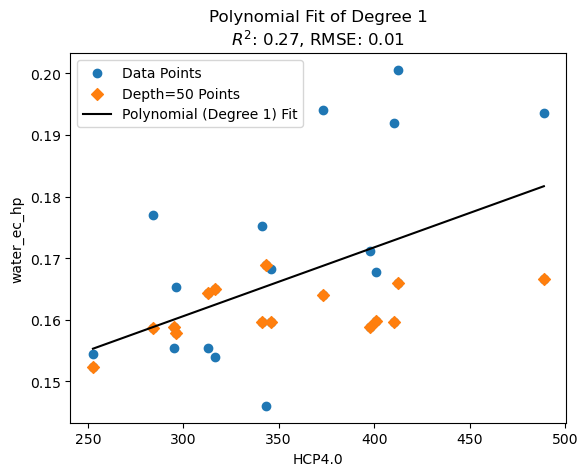

Predicting stochastically water_ec_hp for the 10 cm layer, the best predictor is: HCP4.0 with ply grade: 1


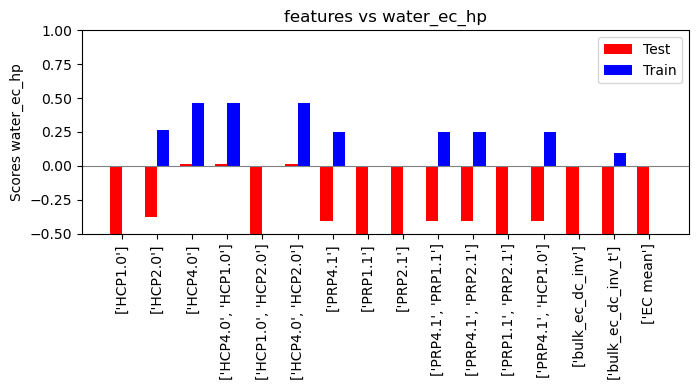

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


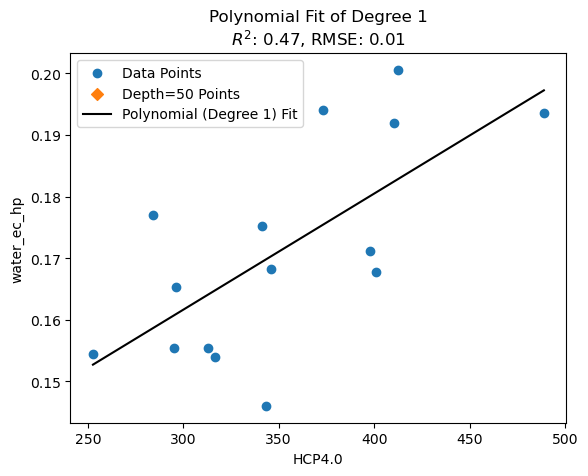

Predicting stochastically water_ec_hp for the 50 cm layer, the best predictor is: HCP1.0 with ply grade: 0


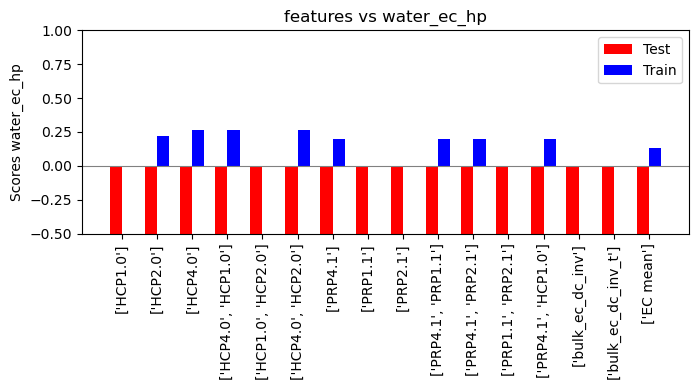

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


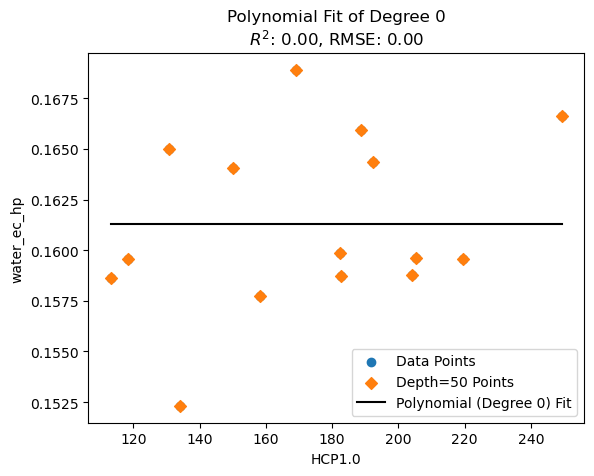

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(HCP4.0, 1)",0.164,"([bulk_ec_dc_inv], 1)",-0.298,"([HCP4.0], 2)",-1.054,"([HCP4.0], 1)",0.344,0.595
1,CEC,"(HCP4.0, 1)",0.016,"([PRP4.1], 1)",-0.374,"([HCP4.0], 1)",-0.846,"([HCP4.0], 1)",0.486,0.173
2,clay,"(HCP1.0, 0)",-0.408,"([HCP1.0], 0)",-0.904,"([HCP1.0], 0)",-0.904,"([HCP1.0], 0)",-0.016,-0.022
3,bd,"(HCP4.0, 1)",-0.183,"([bulk_ec_dc_inv], 1)",-0.042,"([HCP2.0], 1)",-0.454,"([EC mean], 3)",-0.063,0.444
4,water_ec_hp,"(HCP4.0, 1)",-0.105,"([HCP4.0], 1)",0.011,"([HCP1.0], 0)",-1.299,"([HCP4.0], 1)",0.679,0.512


In [19]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

i=0
for t in target_set:
    R2_test, R2_train, n_comb, RMSE_test = [], [], [], []
    R2_test_10, R2_train_10, n_10, RMSE_test_10 = [], [], [], []
    R2_test_50, R2_train_50, n_50, RMSE_test_50 = [], [], [], []
    R2_1050_, RMSE_1050_ = [], []

    target = ds_all[t].values

    for feature_set in feature_sets:        
        best_n_10, R2_test_pol_10, R2_train_pol_10, RMSE_test_pol_10, RMSE_train_pol_10, best_n_50, R2_test_pol_50, R2_train_pol_50, RMSE_test_pol_50, RMSE_train_pol_50, best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, R2_1050, RMSE_1050 = stochastic_poly_(ds_all, feature_set, t)
        
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        n_comb.append(best_n)
        RMSE_test.append(RMSE_test_pol)

        R2_test_10.append(R2_test_pol_10)
        R2_train_10.append(R2_train_pol_10)
        n_10.append(best_n_10)
        RMSE_test_10.append(RMSE_test_pol_10)

        R2_test_50.append(R2_test_pol_50)
        R2_train_50.append(R2_train_pol_50)
        n_50.append(best_n_50)
        RMSE_test_50.append(RMSE_test_pol_50)

        R2_1050_.append(R2_1050)
        RMSE_1050_.append(RMSE_1050)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n_ = n_comb[best_index]
    R2_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2 combined'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE combined'][i] = RMSE_test[best_index]
    print('Predicting stochastically '+t+' with combined layer modelling, the best predictor is: ' +feature_sets[best_index][0]+' with ply grade: '+str(n_))
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n_)

    best_index_10 = RMSE_test_10.index(np.min(RMSE_test_10))
    n_10_ = n_10[best_index_10]
    R2_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    R2_stochastic['R2 '+str(10)+'cm'][i] = R2_test_10[best_index_10]
    RMSE_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    RMSE_stochastic['RMSE '+str(10)+'cm'][i] = RMSE_test_10[best_index_10]
    print('Predicting stochastically '+t+' for the 10 cm layer, the best predictor is: ' +feature_sets[best_index_10][0]+' with ply grade: '+str(n_10_))
    bars_plot(feature_sets, R2_test_10, R2_train_10, t)
    implementation(ds_all[ds_all['depth'] == 10], feature_sets[best_index_10], t, n_10_)

    best_index_50 = RMSE_test_50.index(np.min(RMSE_test_50))
    n_50_ = n_50[best_index_50]
    R2_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    R2_stochastic['R2 '+str(50)+'cm'][i] = R2_test_50[best_index_50]
    RMSE_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    RMSE_stochastic['RMSE '+str(50)+'cm'][i] = RMSE_test_50[best_index_50]
    print('Predicting stochastically '+t+' for the 50 cm layer, the best predictor is: ' +feature_sets[best_index_50][0]+' with ply grade: '+str(n_50_))
    bars_plot(feature_sets, R2_test_50, R2_train_50, t)
    implementation(ds_all[ds_all['depth'] == 50], feature_sets[best_index_50], t, n_50_)

    best_index_1050 = R2_1050_.index(np.max(R2_1050_))
    R2_stochastic['R2 combined2'][i] = R2_1050_[best_index_1050]
    RMSE_stochastic['RMSE combined2'][i] = RMSE_1050_[best_index_1050]

    i+=1

R2_stochastic

In [20]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(HCP4.0, 1)",0.045,"([bulk_ec_dc_inv], 1)",0.051,"([HCP4.0], 2)",0.041,"([HCP4.0], 1)",0.042,0.037
1,CEC,"(HCP4.0, 1)",1.416,"([PRP4.1], 1)",1.047,"([HCP4.0], 1)",1.588,"([HCP4.0], 1)",1.095,1.03
2,clay,"(HCP1.0, 0)",7.626,"([HCP1.0], 0)",5.175,"([HCP1.0], 0)",9.137,"([HCP1.0], 0)",8.594,8.386
3,bd,"(HCP4.0, 1)",0.089,"([bulk_ec_dc_inv], 1)",0.049,"([HCP2.0], 1)",0.098,"([EC mean], 3)",0.071,0.048
4,water_ec_hp,"(HCP4.0, 1)",0.012,"([HCP4.0], 1)",0.014,"([HCP1.0], 0)",0.004,"([HCP4.0], 1)",0.007,0.008
